In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import tqdm
import datetime
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_usage = pd.read_csv('data/App_usage_trace.txt', sep=' ', names=['user', 'time', 'location', 'app', 'traffic'])
df_usage2 = df_usage[['user', 'time', 'app']]
df_loc = df_usage['location']
df_usage2.head()

,user,time,app
0,0,20160420081319,361
1,0,20160420081320,361
2,0,20160420081322,361
3,0,20160420081330,361
4,0,20160420081331,361


In [3]:
# merging the consecutive usage records of the same app in one minute
df_usage2['time'] = df_usage2['time'].apply(lambda x : str(x)[:-2])
df_usage2.drop_duplicates(inplace=True)

C:\Users\69482\AppData\Local\Temp/ipykernel_21380/4140628987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usage2['time'] = df_usage2['time'].apply(lambda x : str(x)[:-2])
C:\Users\69482\AppData\Local\Temp/ipykernel_21380/4140628987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usage2.drop_duplicates(inplace=True)


In [4]:
df_usage2

,user,time,app
0,0,201604200813,361
5,0,201604200816,361
6,0,201604200816,31
7,0,201604200816,360
8,0,201604200816,612
...,...,...,...
4171944,999,201604262218,1
4171945,999,201604262219,5
4171947,999,201604262220,5
4171948,999,201604262234,5


In [5]:
# delete app used less than 10 times for all users
df_usage2 = df_usage2[df_usage2.groupby('app')['app'].transform('count').ge(10)]

In [6]:
df_usage2

,user,time,app
0,0,201604200813,361
5,0,201604200816,361
6,0,201604200816,31
7,0,201604200816,360
8,0,201604200816,612
...,...,...,...
4171944,999,201604262218,1
4171945,999,201604262219,5
4171947,999,201604262220,5
4171948,999,201604262234,5


In [7]:
len(df_usage2['app'].drop_duplicates())

1521

In [8]:
df_usage = df_usage2.join(df_loc)

In [14]:
df_usage[10:15]

,user,time,app,location
19,0,201604200829,612,1906
20,0,201604200829,360,1906
22,0,201604200829,4,1906
23,0,201604200831,31,1906
24,0,201604200847,1,1307


In [12]:
df_usage[10000:10005]

,user,time,app,location
33721,114,201604211314,227,450
33722,114,201604211336,249,450
33723,114,201604211346,249,377
33724,114,201604211347,227,377
33725,114,201604211356,249,450


In [18]:
prev_user = -1
prev_time = -1
app_seq = []
time_seq = []
all_app_seq = []
all_time_seq = []

seq_length = 4

# df_usage is already sorted based on user and time sequence
for i in tqdm.tqdm(range(len(df_usage))):
    user = df_usage.iloc[i]['user']
    app = df_usage.iloc[i]['app']
    loc = df_usage.iloc[i]['location']
    time = df_usage.iloc[i]['time']
    time = datetime.datetime.strptime(time, '%Y%m%d%H%M')

    if prev_user != user:
        app_seq = [app]
        time_seq = [time]
        all_app_seq.append([])
        all_time_seq.append([])

    else:
        # same sequence if the time gap between them is equal to or less than 7 mins
        if (time - prev_time).total_seconds() // 60 <= 7:
            if len(app_seq) == seq_length:
                all_app_seq.append(app_seq)
                # 差分时间
                all_time_seq.append([(prev_time - x).total_seconds() // 60 for x in time_seq])
                app_seq = app_seq[1:] + [app]
                time_seq = time_seq[1:] + [time]
            else:
                app_seq.append(app)
                time_seq.append(time)
                all_app_seq.append([])
                all_time_seq.append([])
        else:
            app_seq = [app]
            time_seq = [time]
            all_app_seq.append([])
            all_time_seq.append([])
        
    prev_user = user
    prev_time = time

100%|██████████| 1123955/1123955 [12:17<00:00, 1523.06it/s]


In [19]:
df_usage['app_seq'] = all_app_seq
df_usage['time_seq'] = all_time_seq

# only filled sequences are treated as data
df_usage = df_usage[df_usage['app_seq'].map(len) != 0]
# delete users who have sequences less than 50
df_usage = df_usage[df_usage.groupby('user')['user'].transform('count').ge(50)]

df_usage.head()

,user,time,app,location,app_seq,time_seq
8,0,201604200816,612,8194,"[361, 361, 31, 360]","[3.0, 0.0, 0.0, 0.0]"
10,0,201604200817,31,8194,"[361, 31, 360, 612]","[0.0, 0.0, 0.0, 0.0]"
13,0,201604200817,360,8194,"[31, 360, 612, 31]","[1.0, 1.0, 1.0, 0.0]"
14,0,201604200817,361,8194,"[360, 612, 31, 360]","[1.0, 1.0, 0.0, 0.0]"
16,0,201604200824,1,8192,"[612, 31, 360, 361]","[1.0, 0.0, 0.0, 0.0]"


In [235]:
df_usage.to_csv('data/baseline_loc_time.txt', sep='\t', index=False)

In [4]:
import ast 

df_usage = pd.read_csv('data/baseline_loc_time.txt', sep='\t')
df_usage['app_seq'] = df_usage['app_seq'].apply(ast.literal_eval)
df_usage['time_seq'] = df_usage['time_seq'].apply(ast.literal_eval)
df_usage['time'] = df_usage['time'].apply(lambda x: str(x))

In [20]:
df_usage.head()

,user,time,app,location,app_seq,time_seq
8,0,201604200816,612,8194,"[361, 361, 31, 360]","[3.0, 0.0, 0.0, 0.0]"
10,0,201604200817,31,8194,"[361, 31, 360, 612]","[0.0, 0.0, 0.0, 0.0]"
13,0,201604200817,360,8194,"[31, 360, 612, 31]","[1.0, 1.0, 1.0, 0.0]"
14,0,201604200817,361,8194,"[360, 612, 31, 360]","[1.0, 1.0, 0.0, 0.0]"
16,0,201604200824,1,8192,"[612, 31, 360, 361]","[1.0, 0.0, 0.0, 0.0]"


In [21]:
# represent time as weekday_time
def prep_time(t):
    t = t[:-2]
    weekday = datetime.datetime.strptime(t[:-2], '%Y%m%d').weekday()
    return '{}_{}'.format(weekday, t[-2:])

df_usage['time'] = df_usage['time'].apply(lambda x : prep_time(x))

In [22]:
df_usage.head()

,user,time,app,location,app_seq,time_seq
8,0,2_08,612,8194,"[361, 361, 31, 360]","[3.0, 0.0, 0.0, 0.0]"
10,0,2_08,31,8194,"[361, 31, 360, 612]","[0.0, 0.0, 0.0, 0.0]"
13,0,2_08,360,8194,"[31, 360, 612, 31]","[1.0, 1.0, 1.0, 0.0]"
14,0,2_08,361,8194,"[360, 612, 31, 360]","[1.0, 1.0, 0.0, 0.0]"
16,0,2_08,1,8192,"[612, 31, 360, 361]","[1.0, 0.0, 0.0, 0.0]"


In [23]:
user2id = {u: i for i, u in enumerate(sorted(df_usage['user'].unique()))}
loc2id = {l: i for i, l in enumerate(sorted(df_usage['location'].unique()))}
app_set = set()
for s in df_usage['app_seq'].values:
    app_set.update(s)
app2id = {a: i for i, a in enumerate(sorted(app_set))}

In [182]:
time2id = {u: i for i, u in enumerate(sorted(df_usage['time'].unique()))}

In [184]:
time_nums = len(time2id)
print("time nums: " + str(len(time2id)))

time nums: 168


In [24]:
user_nums = len(user2id)
loc_nums = len(loc2id)
app_nums = len(app2id)
print("user nums: " + str(len(user2id)))
print("loc nums: " + str(len(loc2id)))
print("app nums: " + str(len(app2id)))

user nums: 748
loc nums: 6291
app nums: 1518


In [10]:
def dict2file(dic, filename):
    with open(filename, 'w') as f:
        for k, v in dic.items():
            f.write("{}\t{}\n".format(k, v))

In [182]:
dict2file(loc2id, "data/loc2id.txt")

In [26]:
df_dataset = pd.DataFrame()
df_dataset['user'] = df_usage['user'].apply(lambda x : user2id[x])
df_dataset['time'] = df_usage['time']
df_dataset['location'] = df_usage['location'].apply(lambda x : loc2id[x])
df_dataset['app_seq'] = df_usage['app_seq'].apply(lambda x : [app2id[c] for c in x])
df_dataset['time_seq'] = df_usage['time_seq']
df_dataset['app'] = df_usage['app'].apply(lambda x : app2id[x])

In [34]:
df_dataset

,user,time,location,app_seq,time_seq,app
8,0,2_08,5232,"[290, 290, 20, 289]","[3.0, 0.0, 0.0, 0.0]",516
10,0,2_08,5232,"[290, 20, 289, 516]","[0.0, 0.0, 0.0, 0.0]",20
13,0,2_08,5232,"[20, 289, 516, 20]","[1.0, 1.0, 1.0, 0.0]",289
14,0,2_08,5232,"[289, 516, 20, 289]","[1.0, 1.0, 0.0, 0.0]",290
16,0,2_08,5230,"[516, 20, 289, 290]","[1.0, 0.0, 0.0, 0.0]",0
...,...,...,...,...,...,...
4171942,747,1_22,243,"[778, 3, 87, 307]","[1.0, 0.0, 0.0, 0.0]",49
4171943,747,1_22,243,"[3, 87, 307, 49]","[0.0, 0.0, 0.0, 0.0]",0
4171944,747,1_22,243,"[87, 307, 49, 0]","[1.0, 1.0, 1.0, 0.0]",0
4171945,747,1_22,243,"[307, 49, 0, 0]","[2.0, 2.0, 1.0, 0.0]",3


#### 训练测试集划分并保存

In [28]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_dataset, test_size=0.2, random_state=2021, stratify=df_dataset['user'])
print(train.shape)
print(test.shape)

(727016, 6)
(181754, 6)


In [245]:
train.to_csv('data/train_poi.txt', sep='\t', index=False)
test.to_csv('data/test_poi.txt', sep='\t', index=False)

#### 四个变量相关性

In [70]:
df = df_dataset[["user", "time", "location", "app"]]
df.head()

,user,time,location,app
8,0,2_08,5232,516
10,0,2_08,5232,20
13,0,2_08,5232,289
14,0,2_08,5232,290
16,0,2_08,5230,0


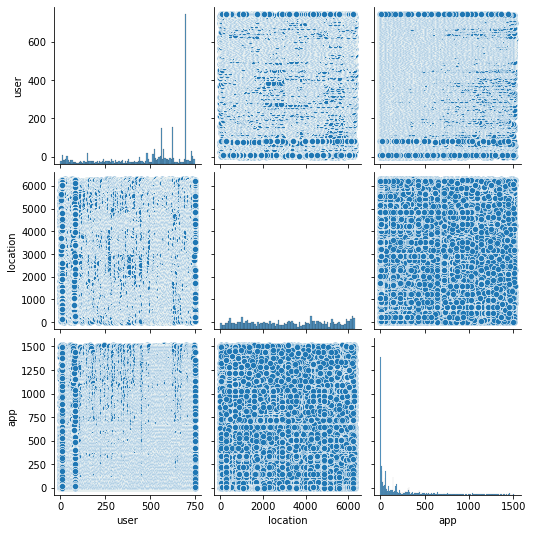

In [72]:
sns.pairplot(df)

###  1. App与user分析

In [280]:
app_df = df_dataset['app']
user_df = df_dataset['user']
len(app_df)

908770

In [42]:
app_user = df_dataset.groupby('app')['user'].apply(list).reset_index()
app_user

,app,user
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ..."
2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 8..."
...,...,...
1510,1513,"[698, 698, 698, 698, 698, 698, 698, 698, 698, ..."
1511,1514,"[294, 294, 294, 294, 294, 294]"
1512,1515,"[162, 162, 242, 242, 242, 242, 242, 242, 242, ..."
1513,1516,"[3, 53, 53, 53, 53, 53, 53, 53, 698, 698, 698,..."


In [45]:
counter = Counter()
user_nums_df = np.zeros(len(app_user), dtype=int)
for i in range(len(app_user)):
    app = app_user.iloc[i]['app']
    counter[app] = Counter(app_user.iloc[i]['user'])
    counter[app] = sorted(counter[app].items(), key=lambda x:x[1], reverse=True)
    user_nums_df[i] = len(counter[app])

In [46]:
app_user['user_nums'] = user_nums_df
app_user

,app,user,user_nums
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",709
1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...",445
2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",366
3,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",380
4,4,"[82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 8...",135
...,...,...,...
1510,1513,"[698, 698, 698, 698, 698, 698, 698, 698, 698, ...",1
1511,1514,"[294, 294, 294, 294, 294, 294]",1
1512,1515,"[162, 162, 242, 242, 242, 242, 242, 242, 242, ...",2
1513,1516,"[3, 53, 53, 53, 53, 53, 53, 53, 698, 698, 698,...",3


In [47]:
keys = []
user_top10 = []
for key, values in counter.items():
    keys.append(key)
    user_top10.append(values[:10])

In [49]:
app_user_dict_top10 = dict(zip(keys, user_top10))
app_user_dict_top10

{0: [(698, 7566),
  (565, 4065),
  (624, 2381),
  (520, 1535),
  (521, 1526),
  (558, 1390),
  (623, 1267),
  (482, 1253),
  (13, 1220),
  (570, 1173)],
 1: [(698, 8102),
  (565, 5140),
  (620, 2334),
  (482, 2311),
  (40, 1656),
  (575, 1651),
  (731, 1398),
  (574, 1209),
  (624, 1202),
  (513, 1148)],
 2: [(698, 3741),
  (565, 522),
  (148, 437),
  (624, 334),
  (269, 300),
  (153, 299),
  (623, 263),
  (607, 251),
  (171, 189),
  (176, 185)],
 3: [(698, 6155),
  (565, 2752),
  (623, 1895),
  (624, 1593),
  (574, 1334),
  (482, 1042),
  (523, 881),
  (521, 714),
  (620, 673),
  (513, 548)],
 4: [(698, 1590),
  (305, 680),
  (182, 560),
  (378, 464),
  (624, 451),
  (736, 293),
  (697, 286),
  (371, 285),
  (660, 255),
  (176, 245)],
 5: [(698, 351),
  (563, 105),
  (500, 86),
  (565, 72),
  (697, 37),
  (546, 33),
  (557, 33),
  (150, 29),
  (152, 18),
  (609, 18)],
 6: [(698, 3096),
  (242, 3055),
  (153, 1203),
  (157, 808),
  (152, 695),
  (273, 472),
  (649, 334),
  (446, 299),


In [50]:
app_user_adj = np.zeros((app_nums, user_nums), dtype=int)
app_user_adj.shape

(1518, 748)

In [51]:
for key, user_list in counter.items():
    i = key
    for elem in user_list:
        j = elem[0]
        app_user_adj[i][j] += elem[1]

In [52]:
app_user_adj

array([[ 91,  10,  27, ...,  57, 165, 354],
       [ 10,  80,  99, ...,  16,   3, 165],
       [ 44,  14,   4, ...,   1,  29,  63],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

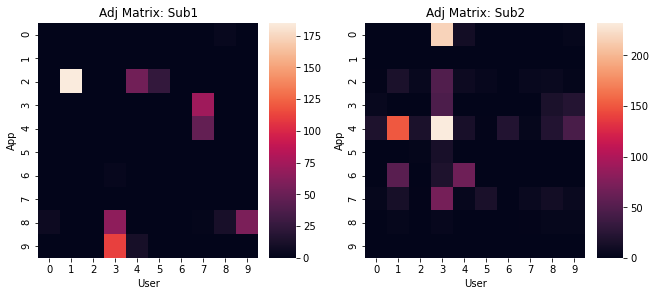

In [224]:
fig1, ax1 = plt.subplots(1,2,constrained_layout=True, figsize=(9,4))
axesSub = sns.heatmap(app_user_adj[10:20, 10:20], ax=ax1[0])
axesSub.set_title('Adj Matrix: Sub1')
axesSub.set_xlabel("User")
axesSub.set_ylabel("App")
axesSub2 = sns.heatmap(app_user_adj[50:60, 10:20], ax=ax1[1])
axesSub2.set_title('Adj Matrix: Sub2')
axesSub2.set_xlabel("User")
axesSub2.set_ylabel("App")
plt.show()

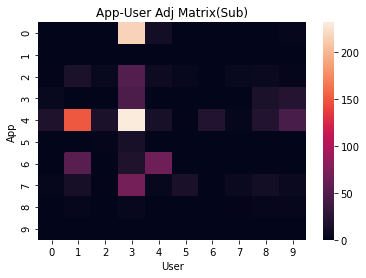

In [226]:
axesSub2 = sns.heatmap(app_user_adj[50:60, 10:20])
axesSub2.set_title('App-User Adj Matrix(Sub)')
axesSub2.set_xlabel("User")
axesSub2.set_ylabel("App")
plt.savefig("AdjMatrixTSH.pdf",dpi=1500)
plt.show()

<Figure size 432x288 with 0 Axes>

In [53]:
nonzero_nums = np.count_nonzero(app_user_adj)
total_nums = app_user_adj.shape[0] * app_user_adj.shape[1]
nonzero_ratio = nonzero_nums / total_nums
nonzero_ratio

0.03999774541509022

In [54]:
print("矩阵非零比例：%.2f" % (nonzero_ratio*100) + "%")

矩阵非零比例：4.00%


##### 观察0-19号，100-110号App被多少个用户使用

In [227]:
example = app_user[["app", "user_nums"]][:20]
example2 = app_user[["app", "user_nums"]][300:320]

d:\Anaconda3\envs\sustech\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\Anaconda3\envs\sustech\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


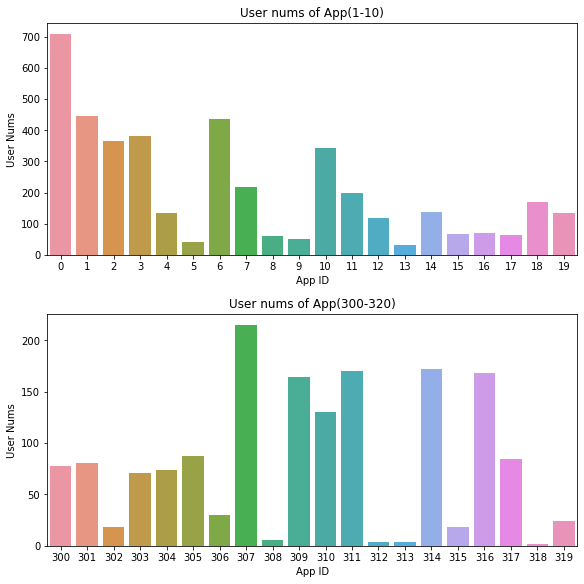

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2,1,constrained_layout=True, figsize=(8,8))
axesSub = sns.barplot(example["app"], example["user_nums"], ax=ax[0])
axesSub.set_title('User nums of App(1-10)')
axesSub.set_xlabel("App ID")
axesSub.set_ylabel("User Nums")
axesSub2 = sns.barplot(example2["app"], example2["user_nums"], ax=ax[1])
axesSub2.set_title('User nums of App(300-320)')
axesSub2.set_xlabel("App ID")
axesSub2.set_ylabel("User Nums")
plt.show()

d:\Anaconda3\envs\sustech\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


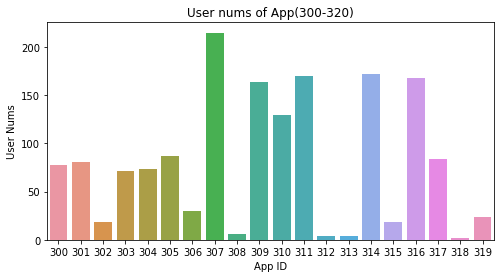

In [228]:
plt.figure(figsize=(8,4))
axesSub2 = sns.barplot(example2["app"], example2["user_nums"])
axesSub2.set_title('User nums of App(300-320)')
axesSub2.set_xlabel("App ID")
axesSub2.set_ylabel("User Nums")
plt.savefig("AppUserExpTSH.pdf",dpi=1500)
plt.show()

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(example["app"], example["user_nums"], ax=ax[0])
plt.show()

d:\Anaconda3\envs\sustech\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [ ]:
axesSub2 = sns.barplot(example2["app"], example2["user_nums"], ax=ax[1])
axesSub2.set_title('User nums of App(300:320')
plt.show()

##### 平均每个App多少用户使用

In [59]:
user_nums_df.mean()

29.977557755775578

##### 观察App的top10用户

In [ ]:
df1 = np.array(app_user_dict_top10[0])
df1

In [285]:
len(user_df)

908770

In [287]:
user_df.drop_duplicates

<bound method Series.drop_duplicates of 8            0
10           0
13           0
14           0
16           0
          ... 
4171942    747
4171943    747
4171944    747
4171945    747
4171947    747
Name: user, Length: 908770, dtype: int64>

In [355]:
au_df = df_dataset[['app', 'user']].sample(n=10000, replace=False)

d:\Anaconda3\envs\sustech\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\Anaconda3\envs\sustech\lib\site-packages\seaborn\distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


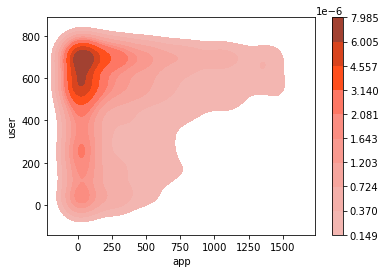

In [356]:
sns.kdeplot(au_df['app'], au_df['user'], shade=True, shade_lowest=False, cbar=True, color='tomato')
axesSub2.set_title('App-User: kde')
plt.savefig("AppUserKdeTSH.pdf",dpi=1500)
plt.show()

### 2. App与time分析

In [187]:
df_dataset['time'] = df_usage['time'].apply(lambda x : time2id[x])

In [188]:
time_nums = len(df_dataset['time'].drop_duplicates())
time_nums

168

In [189]:
app_time = df_dataset.groupby('app')['time'].apply(list).reset_index()
app_time

,app,time
0,0,"[56, 68, 80, 81, 81, 83, 83, 90, 90, 90, 91, 9..."
1,1,"[105, 105, 105, 105, 105, 105, 105, 10, 10, 10..."
2,2,"[56, 80, 80, 80, 80, 80, 81, 90, 93, 93, 93, 9..."
3,3,"[81, 81, 81, 81, 81, 83, 90, 91, 93, 97, 104, ..."
4,4,"[63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 6..."
...,...,...
1510,1513,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1511,1514,"[85, 85, 105, 110, 113, 14]"
1512,1515,"[17, 17, 61, 64, 91, 91, 113, 113, 114, 114]"
1513,1516,"[41, 59, 104, 104, 154, 154, 8, 8, 54, 58, 58,..."


In [190]:
app_df = df_dataset['app']
time_df = df_dataset['time']
len(app_df)

908770

In [191]:
counter2 = Counter()
time_nums_df = np.zeros(len(app_time), dtype=int)
for i in range(len(app_time)):
    app = app_time.iloc[i]['app']
    counter2[app] = Counter(app_time.iloc[i]['time'])
    counter2[app] = sorted(counter2[app].items(), key=lambda x:x[1], reverse=True)
    time_nums_df[i] = len(counter2[app])

In [192]:
app_time['time_nums'] = time_nums_df
app_time

,app,time,time_nums
0,0,"[56, 68, 80, 81, 81, 83, 83, 90, 90, 90, 91, 9...",168
1,1,"[105, 105, 105, 105, 105, 105, 105, 10, 10, 10...",167
2,2,"[56, 80, 80, 80, 80, 80, 81, 90, 93, 93, 93, 9...",167
3,3,"[81, 81, 81, 81, 81, 83, 90, 91, 93, 97, 104, ...",168
4,4,"[63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 6...",157
...,...,...,...
1510,1513,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1511,1514,"[85, 85, 105, 110, 113, 14]",5
1512,1515,"[17, 17, 61, 64, 91, 91, 113, 113, 114, 114]",6
1513,1516,"[41, 59, 104, 104, 154, 154, 8, 8, 54, 58, 58,...",20


In [193]:
app_time_adj = np.zeros((app_nums, time_nums), dtype=int)
app_time_adj.shape

(1518, 168)

In [194]:
for key, time_list in counter2.items():
    i = key
    for elem in time_list:
        j = elem[0]
        app_time_adj[i][j] += elem[1]

In [195]:
app_time_adj

array([[159, 117,  27, ..., 437, 414, 291],
       [170,  31,  28, ..., 318, 417, 254],
       [  5,   5,   7, ...,  81,  43,  26],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

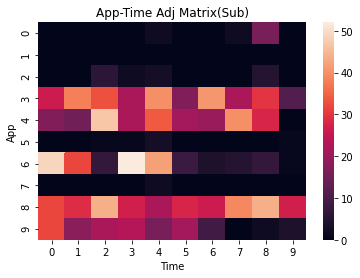

In [229]:
axesSub2 = sns.heatmap(app_time_adj[110:120, 10:20])
axesSub2.set_title('App-Time Adj Matrix(Sub)')
axesSub2.set_xlabel("Time")
axesSub2.set_ylabel("App")
plt.savefig("AdjMatrixTSH_t.pdf",dpi=1500)
plt.show()

In [199]:
nonzero_nums = np.count_nonzero(app_time_adj)
total_nums = app_time_adj.shape[0] * app_time_adj.shape[1]
nonzero_ratio = nonzero_nums / total_nums
nonzero_ratio

0.32156973461321287

In [200]:
print("矩阵非零比例：%.2f" % (nonzero_ratio*100) + "%")

矩阵非零比例：32.16%


In [230]:
example = app_time[["app", "time_nums"]][:20]
example2 = app_time[["app", "time_nums"]][300:320]

d:\Anaconda3\envs\sustech\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


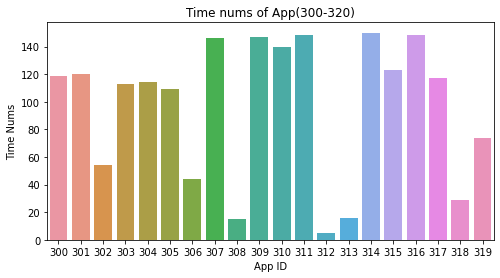

In [231]:
plt.figure(figsize=(8,4))
axesSub2 = sns.barplot(example2["app"], example2["time_nums"])
axesSub2.set_title('Time nums of App(300-320)')
axesSub2.set_xlabel("App ID")
axesSub2.set_ylabel("Time Nums")
plt.savefig("AppTimeExpTSH.pdf",dpi=1500)
plt.show()

##### 平均每个App有多少个时间箱

In [204]:
time_nums_df.mean()

54.13069306930693

In [357]:
at_df = df_dataset[['app', 'time']].sample(n=10000, replace=False)

d:\Anaconda3\envs\sustech\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\Anaconda3\envs\sustech\lib\site-packages\seaborn\distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


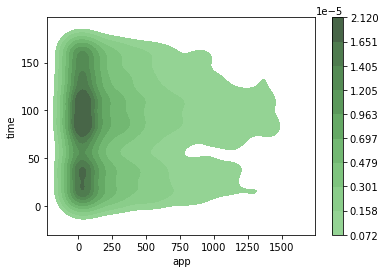

In [358]:
sns.kdeplot(at_df['app'], at_df['time'], shade=True, shade_lowest=False, cbar=True, color='lightgreen')
axesSub2.set_title('App-Time: kde')
plt.savefig("AppTimeKdeTSH.pdf",dpi=1500)
plt.show()

### 3. App与location分析

In [232]:
loc_nums = len(df_dataset['location'].drop_duplicates())
loc_nums

6291

In [233]:
app_loc = df_dataset.groupby('app')['location'].apply(list).reset_index()
app_loc

,app,location
0,0,"[5230, 1008, 5230, 4356, 4356, 4632, 4632, 488..."
1,1,"[1142, 1142, 1142, 1142, 1142, 1142, 1142, 463..."
2,2,"[1181, 5232, 5230, 5178, 4889, 1432, 4356, 480..."
3,3,"[4356, 4356, 4356, 4356, 4356, 4632, 4801, 480..."
4,4,"[1120, 1120, 1120, 1120, 1120, 1120, 1120, 112..."
...,...,...
1510,1513,"[5703, 5703, 5703, 5703, 5703, 5703, 5703, 570..."
1511,1514,"[24, 24, 24, 24, 23, 5967]"
1512,1515,"[3444, 3643, 1547, 1547, 1547, 1547, 1547, 154..."
1513,1516,"[1112, 1605, 1605, 1605, 4237, 4237, 989, 1192..."


In [234]:
app_df = df_dataset['app']
loc_df = df_dataset['location']
len(app_df)

908770

In [236]:
counter3 = Counter()
loc_nums_df = np.zeros(len(app_loc), dtype=int)
for i in range(len(app_loc)):
    app = app_loc.iloc[i]['app']
    counter3[app] = Counter(app_loc.iloc[i]['location'])
    counter3[app] = sorted(counter3[app].items(), key=lambda x:x[1], reverse=True)
    loc_nums_df[i] = len(counter3[app])

In [237]:
app_loc['loc_nums'] = loc_nums_df
app_loc

,app,location,loc_nums
0,0,"[5230, 1008, 5230, 4356, 4356, 4632, 4632, 488...",4694
1,1,"[1142, 1142, 1142, 1142, 1142, 1142, 1142, 463...",3406
2,2,"[1181, 5232, 5230, 5178, 4889, 1432, 4356, 480...",2876
3,3,"[4356, 4356, 4356, 4356, 4356, 4632, 4801, 480...",3217
4,4,"[1120, 1120, 1120, 1120, 1120, 1120, 1120, 112...",1104
...,...,...,...
1510,1513,"[5703, 5703, 5703, 5703, 5703, 5703, 5703, 570...",1
1511,1514,"[24, 24, 24, 24, 23, 5967]",3
1512,1515,"[3444, 3643, 1547, 1547, 1547, 1547, 1547, 154...",3
1513,1516,"[1112, 1605, 1605, 1605, 4237, 4237, 989, 1192...",15


In [238]:
app_loc_adj = np.zeros((app_nums, loc_nums), dtype=int)
app_loc_adj.shape

(1518, 6291)

In [239]:
for key, loc_list in counter3.items():
    i = key
    for elem in loc_list:
        j = elem[0]
        app_loc_adj[i][j] += elem[1]

In [240]:
app_loc_adj

array([[ 1,  2,  0, ...,  1,  1,  1],
       [11,  2,  0, ...,  0,  1,  0],
       [ 3,  0,  0, ...,  4,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

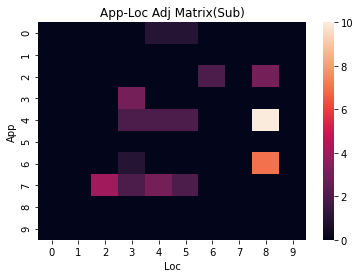

In [248]:
axesSub3 = sns.heatmap(app_loc_adj[50:60, 10:20])
axesSub3.set_title('App-Loc Adj Matrix(Sub)')
axesSub3.set_xlabel("Loc")
axesSub3.set_ylabel("App")
plt.savefig("AdjMatrixTSH_l.pdf",dpi=1500)
plt.show()

In [249]:
nonzero_nums = np.count_nonzero(app_loc_adj)
total_nums = app_loc_adj.shape[0] * app_loc_adj.shape[1]
nonzero_ratio = nonzero_nums / total_nums
nonzero_ratio

0.0220934857061

In [250]:
print("矩阵非零比例：%.2f" % (nonzero_ratio*100) + "%")

矩阵非零比例：2.21%


In [251]:
example = app_loc[["app", "loc_nums"]][:20]
example2 = app_loc[["app", "loc_nums"]][300:320]

d:\Anaconda3\envs\sustech\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


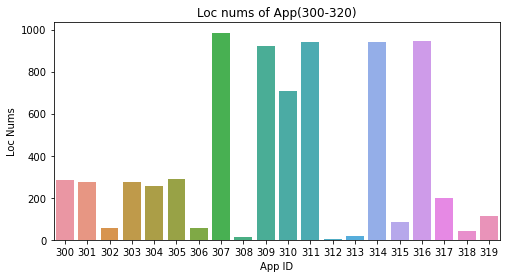

In [252]:
plt.figure(figsize=(8,4))
axesSub2 = sns.barplot(example2["app"], example2["loc_nums"])
axesSub2.set_title('Loc nums of App(300-320)')
axesSub2.set_xlabel("App ID")
axesSub2.set_ylabel("Loc Nums")
plt.savefig("AppLocExpTSH.pdf",dpi=1500)
plt.show()

In [253]:
loc_nums_df.mean()

139.26534653465347

In [345]:
al_df = df_dataset[['app', 'location']].sample(n=10000, replace=False)

d:\Anaconda3\envs\sustech\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\Anaconda3\envs\sustech\lib\site-packages\seaborn\distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


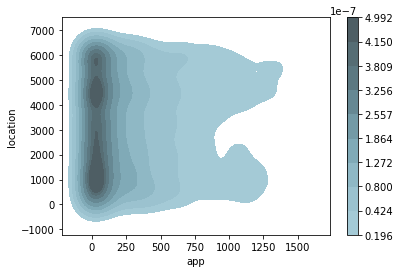

In [346]:
sns.kdeplot(al_df['app'], al_df['location'], shade=True, shade_lowest=False, cbar=True, color='lightblue')
axesSub2.set_title('App-Loc: kde')
plt.savefig("AppLocKdeTSH.pdf",dpi=1500)
plt.show()

#### app-loc矩阵

In [ ]:
app_loc = df_dataset.groupby('app')['location'].apply(list).reset_index()

In [ ]:
app_loc

,app,location
0,0,"[5230, 1008, 5230, 4356, 4356, 4632, 4632, 488..."
1,1,"[1142, 1142, 1142, 1142, 1142, 1142, 1142, 463..."
2,2,"[1181, 5232, 5230, 5178, 4889, 1432, 4356, 480..."
3,3,"[4356, 4356, 4356, 4356, 4356, 4632, 4801, 480..."
4,4,"[1120, 1120, 1120, 1120, 1120, 1120, 1120, 112..."
...,...,...
1510,1513,"[5703, 5703, 5703, 5703, 5703, 5703, 5703, 570..."
1511,1514,"[24, 24, 24, 24, 23, 5967]"
1512,1515,"[3444, 3643, 1547, 1547, 1547, 1547, 1547, 154..."
1513,1516,"[1112, 1605, 1605, 1605, 4237, 4237, 989, 1192..."


In [ ]:
counter = Counter()
loc_nums_df = np.zeros(len(app_loc), dtype=int)
for i in range(len(app_loc)):
    app = app_loc.iloc[i]['app']
    counter[app] = Counter(app_loc.iloc[i]['location'])
    counter[app] = sorted(counter[app].items(), key=lambda x:x[1], reverse=True)
    loc_nums_df[i] = len(counter[app])

In [ ]:
app_loc['loc_nums'] = loc_nums_df

In [ ]:
app_loc

,app,location,loc_nums
0,0,"[5230, 1008, 5230, 4356, 4356, 4632, 4632, 488...",4694
1,1,"[1142, 1142, 1142, 1142, 1142, 1142, 1142, 463...",3406
2,2,"[1181, 5232, 5230, 5178, 4889, 1432, 4356, 480...",2876
3,3,"[4356, 4356, 4356, 4356, 4356, 4632, 4801, 480...",3217
4,4,"[1120, 1120, 1120, 1120, 1120, 1120, 1120, 112...",1104
...,...,...,...
1510,1513,"[5703, 5703, 5703, 5703, 5703, 5703, 5703, 570...",1
1511,1514,"[24, 24, 24, 24, 23, 5967]",3
1512,1515,"[3444, 3643, 1547, 1547, 1547, 1547, 1547, 154...",3
1513,1516,"[1112, 1605, 1605, 1605, 4237, 4237, 989, 1192...",15


In [ ]:
keys = []
loc_top10 = []
for key, values in counter.items():
    keys.append(key)
    loc_top10.append(values[:10])

In [ ]:
app_loc_dict_top10 = dict(zip(keys, loc_top10))

#### 生成矩阵，每行表示一个app的loc分布，每列表示一个loc的app分布

In [ ]:
app_nums

1518

In [ ]:
loc_nums

6291

In [ ]:
app_loc_adj = np.zeros((app_nums, loc_nums), dtype=int)
app_loc_adj.shape

(1518, 6291)

In [ ]:
for key, loc_list in counter.items():
    i = key
    for elem in loc_list:
        j = elem[0]
        app_loc_adj[i][j] += elem[1]

In [ ]:
app_loc_adj

array([[ 1,  2,  0, ...,  1,  1,  1],
       [11,  2,  0, ...,  0,  1,  0],
       [ 3,  0,  0, ...,  4,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

#### 统计矩阵稀疏性

In [ ]:
nonzero_nums = np.count_nonzero(app_loc_adj)
total_nums = app_loc_adj.shape[0] * app_loc_adj.shape[1]
nonzero_ratio = nonzero_nums / total_nums
nonzero_ratio

0.0220934857061

In [ ]:
print("矩阵非零比例：%.2f" % (nonzero_ratio*100) + "%")

矩阵非零比例：2.21%


#### 观察app出现的location数目的分布和均值

In [ ]:
example = loc_nums_df[10:20]
example

array([1162,  596,  627,  302,  620,  396,  415,  294, 1020,  593])

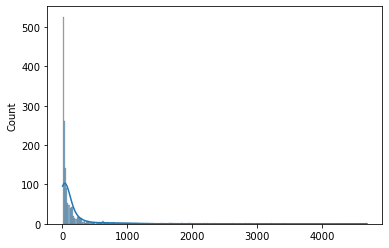

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(loc_nums_df, kde=True)
plt.show()

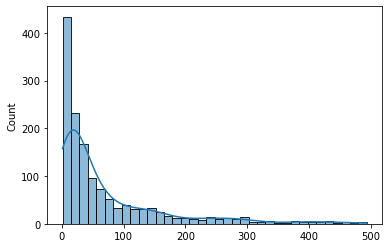

In [ ]:
sns.histplot(loc_nums_df[loc_nums_df<500], kde=True)
plt.show()

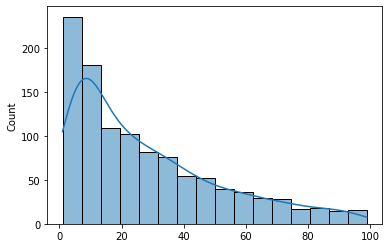

In [ ]:
sns.histplot(loc_nums_df[loc_nums_df<100], kde=True)
plt.show()

In [ ]:
loc_nums_df.mean()

139.26534653465347

In [ ]:
df1 = np.array(app_loc_dict_top10[0])
df1

array([[5193,  725],
       [5315,  687],
       [5901,  635],
       [ 992,  512],
       [4850,  426],
       [6200,  404],
       [5115,  381],
       [3989,  340],
       [5930,  334],
       [5722,  295]])

In [ ]:
df2 = np.array(app_loc_dict_top10[300])
df2

array([[1263,   34],
       [ 982,   28],
       [6129,   23],
       [ 540,   15],
       [5296,   11],
       [1951,   11],
       [ 125,   10],
       [  45,   10],
       [ 506,   10],
       [6149,    9]])

In [ ]:
df3 = np.array(app_loc_dict_top10[700])
df3

array([[1995,   61],
       [6146,   37],
       [1997,   27],
       [ 426,   14],
       [5869,    7],
       [6049,    6],
       [2298,    3],
       [6179,    3],
       [6011,    3],
       [6151,    3]])